In [1]:
import pandas as pd
import json
import numpy as np

from IPython.display import HTML
from visualizer import visualize

from kaggle_environments.envs.football.helpers import *
from kaggle_environments import make

pd.set_option("display.float_format", lambda x: "%.8f" % x)
pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 150)

np.set_printoptions(suppress=True)

In [2]:
env = make("football", debug=False,
           configuration={"save_video": False, 
                          "scenario_name": 'academy_3_vs_1_with_keeper', 
                          "running_in_notebook": True,
                          #"numSteps": 500
                         })

agent1 = "stest.py"
agent2 = "do_nothing"
#agent2 = "../submit_agents/gfootball-with-memory-patterns/submission_v55.py"
output = env.run([agent1, agent2])

scores = output[-1][0]["observation"]["players_raw"][0]["score"]
print("Scores  {0} : {1}".format(*scores))
print("Rewards {0} : {1}".format(output[-1][0]["reward"], output[-1][1]["reward"]))
print('NUM STEPS: {0}'.format(len(output)))

Scores  0 : 0
Rewards 0 : 0
NUM STEPS: 55


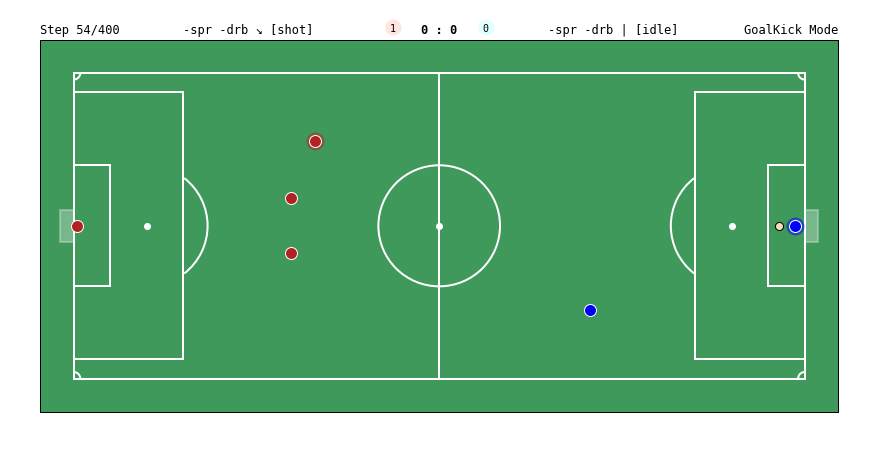

In [3]:
viz = visualize(output)
HTML(viz.to_html5_video())

# Angle Analysis

In [11]:
# dictionary of sticky actions
sticky_actions = {
    "left": Action.Left,
    "top_left": Action.TopLeft,
    "top": Action.Top,
    "top_right": Action.TopRight,
    "right": Action.Right,
    "bottom_right": Action.BottomRight,
    "bottom": Action.Bottom,
    "bottom_left": Action.BottomLeft,
    "sprint": Action.Sprint,
    "dribble": Action.Dribble
}

action_set_dic = {
    0: 'idle',
    # movement actions (1-8)
    1: 'left', # run to the left, sticky action.
    2: 'top_left', #run to the top-left, sticky action.
    3: 'top', # run to the top, sticky action.
    4: 'top_right', # run to the top-right, sticky action.
    5: 'right', # run to the right, sticky action.
    6: 'bottom_right', # run to the bottom-right, sticky action.
    7: 'bottom', # run to the bottom, sticky action.
    8: 'bottom_left', # run to the bottom-left, sticky action
    
    # passing / shooting (9-12)
    9: 'long_pass', # perform a long pass to the player on your team. Player to pass the ball to is auto-determined based on the movement direction.
    10: 'high_pass', # perform a high pass, similar to long_pass.
    11: 'short_pass', # perform a short pass, similar to long_pass.
    12: 'shot', # perform a shot, always in the direction of the opponent's goal.
    
    13: 'sprint', # start sprinting, sticky action. Player moves faster, but has worse ball handling.
    14: 'release_direction', # reset current movement direction.
    15: 'release_sprint', # stop sprinting
    16: 'sliding', # perform a slide (effective when not having a ball)
    17: 'dribble', # start dribbling (effective when having a ball), sticky action. Player moves slower, but it is harder to take over the ball from him.
    18: 'release_dribble' # stop dribbling
}


# game_mode - current game mode, one of:
game_mode_dic = {
    0 : 'normal',
    1 : 'kickoff',
    2 : 'goalkick',
    3 : 'freekick',
    4 : 'corner',
    5 : 'throwin',
    6 : 'penalty'
}

def get_basic_df2(output):
    steps = output
    steps_lists = []

    for step_num in range(len(steps)):
        #print(i)
        step = steps[step_num]
        # get left or right player based on if matches team we want
        obs_step = step[0]

        if step_num == 0:
            action = -1
            action_str = 'none'
        else:
            action = obs_step['action'][0]
            action_str = action_set_dic[action]


        status = obs_step['status']
        observation = obs_step['observation']
        obs = observation['players_raw'][0]
        

        active_player = obs['active']
        
        ball_pos = obs["ball"]
        
        active_player_pos = obs["left_team"][obs["active"]]
        active_player_x, active_player_y = active_player_pos
        
        active_player_dir = obs['left_team_direction'][obs['active']]
        active_player_x_dir, active_player_y_dir = active_player_dir
        
        # ball owned team  {-1, 0, 1}, -1 = ball not owned, 0 = left team, 1 = right team.
        ball_owned_team = obs['ball_owned_team']

        game_mode = obs['game_mode']
        game_mode_str = game_mode_dic[game_mode]
        
        # sticky action list
        sticky_actions = list(obs["sticky_actions"])

        # score
        left_score = obs['score'][0]
        right_score = obs['score'][1]

        # steps
        steps_left = obs['steps_left']

        # we need to map ball owned based on if left or right agent
#         if ball_owned_team == -1:
#             off_def_flag = 'none'
#         elif ball_owned_team == 0:
#             off_def_flag = 'offense'
#         elif ball_owned_team == 1:
#             off_def_flag = 'defense'

        # now create dataframe
        step_list = [step_num, int(action), action_str, game_mode_str, active_player, active_player_x, active_player_y,
                     active_player_x_dir, active_player_y_dir, ball_owned_team, sticky_actions, left_score, right_score]
        steps_lists.append(step_list)


    df_columns = ['step_num', 'action', 'action_str', 'game_mode_str', 'act_player','act_player_x', 'act_player_y',
                  'act_player_x_dir', 'act_player_y_dir', 'ball_owned_team', 'sticky_actions','left_score', 'right_score']
    basic_df = pd.DataFrame(steps_lists, columns = df_columns)
    return basic_df

In [12]:
from math import sqrt, atan2, pi
goal_pos = [1,0]


def angle(src, tgt):
    dx = tgt[0] - src[0]
    dy = tgt[1] - src[1]
    theta = round(atan2(dx, -dy) * 180 / pi, 2)
    while theta < 0:
        theta += 360
    return theta

def direction(src, tgt):
    
    #print('direction func, src: {0}, target: {1}'.format(src,tgt))
    theta = angle(src, tgt)
    #print('theta: {0}:'.format(theta))

    if theta >= 360 - 22.5 or theta <= 0 + 22.5:
        return Action.Top
    if 45 - 22.5 <= theta <= 45 + 22.5:
        return Action.TopRight
    if 90 - 22.5 <= theta <= 90 + 22.5:
        return Action.Right
    if 135 - 22.5 <= theta <= 135 + 22.5:
        return Action.BottomRight
    if 180 - 22.5 <= theta <= 180 + 22.5:
        return Action.Bottom
    if 225 - 22.5 <= theta <= 225 + 22.5:
        return Action.BottomLeft
    if 270 - 22.5 <= theta <= 270 + 22.5:
        return Action.Left
    return Action.TopLeft

In [13]:
adf = get_basic_df2(output)

In [14]:
adf.head()

,step_num,action,action_str,game_mode_str,act_player,act_player_x,act_player_y,act_player_x_dir,act_player_y_dir,ball_owned_team,sticky_actions,left_score,right_score
0,0,-1,none,normal,0,-1.01102936,-0.00000000,0.00000000,-0.00000000,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0
1,1,3,top,normal,1,0.60996068,-0.00101889,0.00289874,-0.00133132,-1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",0,0
2,2,13,sprint,normal,1,0.61331946,-0.00289667,0.00150134,-0.00227273,0,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]",0,0
3,3,13,sprint,normal,1,0.61437941,-0.00551921,0.00079870,-0.00294493,0,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]",0,0
4,4,13,sprint,normal,1,0.61493301,-0.00848012,0.00000000,-0.00299043,0,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]",0,0


In [15]:
goal_dir = [1,0]
adf['act_player_angle'] = adf.apply(lambda row: angle([row['act_player_x'], row['act_player_y']], goal_dir), axis=1)
adf['act_player_direction'] = adf.apply(lambda row: direction([row['act_player_x'], row['act_player_y']], goal_dir), axis=1)

In [16]:
adf['pred_act_player_x'] = adf['act_player_x'] + adf['act_player_x_dir']
adf['pred_act_player_y'] = adf['act_player_y'] + adf['act_player_y_dir']

In [18]:
adf

,step_num,action,action_str,game_mode_str,act_player,act_player_x,act_player_y,act_player_x_dir,act_player_y_dir,ball_owned_team,sticky_actions,left_score,right_score,act_player_angle,act_player_direction,pred_act_player_x,pred_act_player_y
0,0,-1,none,normal,0,-1.01102936,-0.00000000,0.00000000,-0.00000000,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0,90.00000000,Action.Right,-1.01102936,-0.00000000
1,1,3,top,normal,1,0.60996068,-0.00101889,0.00289874,-0.00133132,-1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",0,0,90.15000000,Action.Right,0.61285942,-0.00235021
2,2,13,sprint,normal,1,0.61331946,-0.00289667,0.00150134,-0.00227273,0,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]",0,0,90.43000000,Action.Right,0.61482079,-0.00516940
3,3,13,sprint,normal,1,0.61437941,-0.00551921,0.00079870,-0.00294493,0,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]",0,0,90.82000000,Action.Right,0.61517811,-0.00846413
4,4,13,sprint,normal,1,0.61493301,-0.00848012,0.00000000,-0.00299043,0,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]",0,0,91.26000000,Action.Right,0.61493301,-0.01147055
5,5,13,sprint,normal,1,0.61493301,-0.01147055,0.00000000,-0.00299043,0,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]",0,0,91.71000000,Action.Right,0.61493301,-0.01446098
6,6,13,sprint,normal,1,0.61491436,-0.01499628,-0.00000017,-0.00395458,0,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]",0,0,92.23000000,Action.Right,0.61491418,-0.01895087
7,7,4,top_right,normal,1,0.61490345,-0.01944711,0.00000000,-0.00484373,0,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0]",0,0,92.89000000,Action.Right,0.61490345,-0.02429084
8,8,4,top_right,normal,1,0.61490852,-0.02474590,0.00002104,-0.00567040,0,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0]",0,0,93.68000000,Action.Right,0.61492955,-0.03041630
9,9,5,right,normal,1,0.61495531,-0.03083410,0.00007153,-0.00641135,0,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",0,0,94.58000000,Action.Right,0.61502683,-0.03724545


In [17]:
adf[['step_num', 'action_str','act_player_x', 'act_player_x_dir','pred_act_player_x', 
     'act_player_y', 'act_player_y_dir', 'pred_act_player_y']]

,step_num,action_str,act_player_x,act_player_x_dir,pred_act_player_x,act_player_y,act_player_y_dir,pred_act_player_y
0,0,none,-1.01102936,0.00000000,-1.01102936,-0.00000000,-0.00000000,-0.00000000
1,1,top,0.60996068,0.00289874,0.61285942,-0.00101889,-0.00133132,-0.00235021
2,2,sprint,0.61331946,0.00150134,0.61482079,-0.00289667,-0.00227273,-0.00516940
3,3,sprint,0.61437941,0.00079870,0.61517811,-0.00551921,-0.00294493,-0.00846413
4,4,sprint,0.61493301,0.00000000,0.61493301,-0.00848012,-0.00299043,-0.01147055
5,5,sprint,0.61493301,0.00000000,0.61493301,-0.01147055,-0.00299043,-0.01446098
6,6,sprint,0.61491436,-0.00000017,0.61491418,-0.01499628,-0.00395458,-0.01895087
7,7,top_right,0.61490345,0.00000000,0.61490345,-0.01944711,-0.00484373,-0.02429084
8,8,top_right,0.61490852,0.00002104,0.61492955,-0.02474590,-0.00567040,-0.03041630
9,9,right,0.61495531,0.00007153,0.61502683,-0.03083410,-0.00641135,-0.03724545
